**<h1><center>Deep Learning Systems (ENGR-E 533) 
<br>Homework 2 , Fall 2021</h1>**

**Name: Anitha Ganapathy** <br>
**Email: aganapa@iu.edu** <br>


___

## Installing Librosa. 
Librosa is a python package for music and audio analysis.

In [1]:
# !pip install librosa
# !pip install pysoundfile
# !pip install bitstring

## Organizing Imports


In [2]:
# Import Libraries

import librosa
import torch 
import torch.nn as nn 

from torch import optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import copy
import soundfile as sf
import IPython.display as ipd
from google.colab import drive

drive.mount('/content/drive')  

Mounted at /content/drive


In [3]:
print("Torch Version     : ",torch.__version__)
print("Torch Version     : ",torchvision.__version__)
print("Is CUDA available :",torch.cuda.is_available() )

Torch Version     :  1.9.0+cu111
Torch Version     :  0.10.0+cu111
Is CUDA available : True


In [4]:
# Reading the training file

file_s_input = '/content/drive/MyDrive/data/train_clean_male.wav'
file_x_input = '/content/drive/MyDrive/data/train_dirty_male.wav'
file_test_01 = '/content/drive/MyDrive/data/test_x_01.wav'
file_test_02 = '/content/drive/MyDrive/data/test_x_02.wav'

s, sr=librosa.load(file_s_input, sr=None) 
S_input=librosa.stft(s, n_fft=1024, hop_length=512)

sn, sr=librosa.load(file_x_input, sr=None) 
X_input=librosa.stft(sn, n_fft=1024, hop_length=512)

# Reading test 01 file
st_01, sr_01=librosa.load(file_test_01, sr=None) 
X_test_01=librosa.stft(st_01, n_fft=1024, hop_length=512)

# Reading test 02 file
st_02, sr_02=librosa.load(file_test_02, sr=None) 
X_test_02=librosa.stft(st_02, n_fft=1024, hop_length=512)


In [5]:
# Get the magnitudes of training set, and test sets
S_mag = np.abs(S_input).T
X_mag = np.abs(X_input).T
X_test_01_mag = np.abs(X_test_01).T
X_test_02_mag = np.abs(X_test_02).T

print(S_mag.shape, X_mag.shape )
print(X_test_01_mag.shape, X_test_02_mag.shape )

(2459, 513) (2459, 513)
(142, 513) (380, 513)


In [6]:
#  Get cpu or gpu device for training.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

Using cuda:0 device


## 01. Speech Denoising Using Deep Learning





### **Defining Deep Neural network**

In [7]:
# Define model
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeepNeuralNetwork, self).__init__()
        self.flatten =nn.Flatten()
        self.hl_1 = nn.Linear(513, 1024)      # input layer 
        self.hl_2 = nn.Linear(1024, 1024)     # hidden 
        self.hl_3 = nn.Linear(1024, 1024)     # hidden  
        self.output = nn.Linear(1024, 513)    # hidden / o/p 

        self.dropout_layerx = nn.Dropout(p=0.5)

        for mod in self.modules():
          self.weight_initializer(mod)

    def weight_initializer(self, mod):
      if isinstance(mod , nn.Linear):
         nn.init.kaiming_normal_(mod.weight.data, nonlinearity='relu')
          
    def forward(self, x):
        # x = self.flatten(x)
        x = torch.relu(self.hl_1(x))
        x = self.dropout_layerx(x)
        x = torch.relu(self.hl_2(x))
        x = self.dropout_layerx(x)
        x = torch.relu(self.hl_3(x))
        x = self.dropout_layerx(x)
        x = torch.relu(self.output(x))
        return x

model = DeepNeuralNetwork().to(device)
print(model)

DeepNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hl_1): Linear(in_features=513, out_features=1024, bias=True)
  (hl_2): Linear(in_features=1024, out_features=1024, bias=True)
  (hl_3): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=513, bias=True)
  (dropout_layerx): Dropout(p=0.5, inplace=False)
)


### **Model Parameters**
Optimizer <br>
Loss Function

In [8]:
# Defining the optimiser and loss function

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-4)

**In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.**

### Train for problem 1.

In [9]:
def train(X, y, model, loss_fn, optimizer):
  model.train()
  train_loss = 0.0 
  X = torch.from_numpy(X).float().to(device)
  y = torch.from_numpy(y).float().to(device)
  # re initialize the gradients parameters 
  optimizer.zero_grad()
  
  # Compute prediction error
  pred = model(X)  
  loss = torch.sqrt(loss_fn(pred, y))
  # Backpropagation
  loss.backward()
  optimizer.step()
  train_loss= loss.item()
  return train_loss 

In [10]:
def validate(X, y, model, loss_fn, optimizer):
  model.eval()
  validate_loss = 0.0 
  X = torch.from_numpy(X).float().to(device)
  y = torch.from_numpy(y).float().to(device)
  # re initialize the gradients parameters 

  pred = model(X)  
  loss = torch.sqrt(loss_fn(pred, y))
  validate_loss= loss.item()
  return validate_loss

**We also check the model’s performance against the test dataset to ensure it is learning.**

### run for 100 epochs

In [11]:
%%time

y = S_mag 
X = X_mag 
# X_test_01_mag -- test 1
# X_test_02_mag -- test 2

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)

print("X_val shape : ", X_val.shape)
print("y_val shape : ", y_val.shape)

batch_size =16
epochs = 200

epoch_loss = []
validation_epoch_loss = []
# m = len(X_mag)
m = len(X_train)
num_batches = int(m/batch_size)
print("Number of training samples : ", m)
print("Number of Epochs : ", epochs)
print("Number of batches : ", num_batches)

    
for epoch in range(epochs):
    train_loss = 0.0  
    validation_loss = 0.0  
    
    i = 0
    j = batch_size + 1
    for batch in range(num_batches):
      X_batch = X_train[i:j]
      Y_batch = y_train[i:j]
      i = j
      j = j + batch_size    
   
     # print(f"---------------------------------------------------------")
      loss = train(X_batch, Y_batch, model, loss_fn, optimizer)
      train_loss += loss
    train_loss =train_loss/num_batches 
    epoch_loss.append(train_loss)
    # if epoch % 50 == 0:
    #   print("Epoch : ", epoch, "\tTrain_loss : ", train_loss)

    validation_loss = 0.0  
    validation_loss = validate(X_val, y_val, model, loss_fn, optimizer)
    
    validation_epoch_loss.append(validation_loss)
    if epoch % 50 == 0:
      print("Epoch : ", epoch, "\tTrain_loss : ", train_loss,
            "\tValidation_loss : ", validation_loss)
print("Epoch : ", epoch, "\tTrain_loss : ", train_loss,
            "\tValidation_loss : ", validation_loss)


print("Done!")

X_train shape :  (1967, 513)
y_train shape :  (1967, 513)
X_val shape :  (492, 513)
y_val shape :  (492, 513)
Number of training samples :  1967
Number of Epochs :  200
Number of batches :  122
Epoch :  0 	Train_loss :  0.3986664984802731 	Validation_loss :  0.29279273748397827
Epoch :  50 	Train_loss :  0.15607013663307565 	Validation_loss :  0.1688898205757141
Epoch :  100 	Train_loss :  0.13091069029369315 	Validation_loss :  0.15021362900733948
Epoch :  150 	Train_loss :  0.12187872204135676 	Validation_loss :  0.14576514065265656
Epoch :  199 	Train_loss :  0.11229154418726436 	Validation_loss :  0.14564447104930878
Done!
CPU times: user 44.8 s, sys: 890 ms, total: 45.7 s
Wall time: 45.3 s


### Plot train loss for 100 and 100 epochs

In [12]:
len(epoch_loss)

200

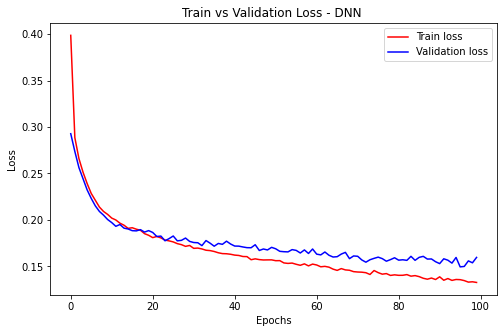

CPU times: user 170 ms, sys: 22.3 ms, total: 192 ms
Wall time: 186 ms


In [13]:
%%time

n = 100

# Plotting the test accuracy results for SGD Optimizer
epochs_range = range(0,epochs)
plt.figure(figsize=(8,5))
plt.plot(epochs_range[:n], epoch_loss[:n], color='red', 
         label='Train loss')
plt.plot(epochs_range[:n], validation_epoch_loss[:n], color='blue', 
         label='Validation loss')

plt.title('Train vs Validation Loss - DNN ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

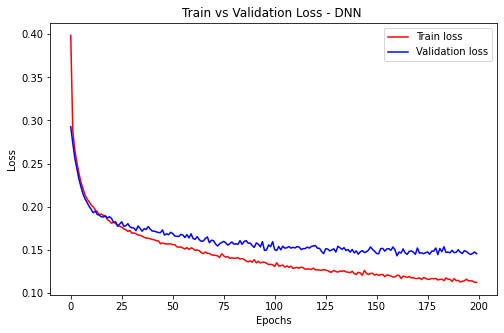

CPU times: user 151 ms, sys: 3.88 ms, total: 155 ms
Wall time: 154 ms


In [14]:
%%time

# Plotting the test accuracy results for SGD Optimizer
epochs_range2 = range(0,epochs)
plt.figure(figsize=(8,5))
plt.plot(epochs_range2, epoch_loss[:500], color='red', 
         label='Train loss')
plt.plot(epochs_range2, validation_epoch_loss, color='blue', 
         label='Validation loss')

plt.title('Train vs Validation Loss - DNN ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Defining the sound recovery function.

In [15]:
def recover_sound(X, mag_X, mag_s_hat):
  return np.multiply((X / mag_X), mag_s_hat)

### Predicting the 2 test audio files

In [16]:
model.eval()

test01_hat = model(torch.from_numpy(X_test_01_mag).float().to(device))
spectogram_test1 = recover_sound(X_test_01, X_test_01_mag.T, test01_hat.T.detach().cpu().numpy() ) 

test02_hat = model(torch.from_numpy(X_test_02_mag).float().to(device))
spectogram_test2 = recover_sound(X_test_02, X_test_02_mag.T, test02_hat.T.detach().cpu().numpy() ) 

In [17]:
recover_test01 = librosa.istft(spectogram_test1, hop_length= 512, win_length=1024)
recover_test02 = librosa.istft(spectogram_test2, hop_length= 512, win_length=1024)

In [18]:
output_file_01 = '/content/drive/MyDrive/data/test_s_01_recovered.wav'
output_file_02 = '/content/drive/MyDrive/data/test_s_02_recovered.wav'
sf.write(output_file_01, recover_test01, sr)
sf.write(output_file_02, recover_test02, sr)

### Listen to original and predicted audio files

**Original test_x_01.wav**

In [19]:
ipd.Audio('/content/drive/MyDrive/data/test_x_01.wav')

**Reconstructed Audio test_s_01_recovered.wav**

In [20]:
ipd.Audio(output_file_01)

**Original test_x_02.wav**

In [21]:
ipd.Audio('/content/drive/MyDrive/data/test_x_02.wav')

**Reconstructed Audio test_s_02_recovered.wav**

In [22]:
ipd.Audio(output_file_02)

## 02. Speech Denoising Using 1D CNN

In [23]:
def out_channels(in_channel, kernel, padding, stride):
  nout = ((in_channel + (2 * padding) - kernel) / stride) + 1
  return int(nout)

print(out_channels(28, 3, 1, 1))
print(out_channels(1, 5, 2, 1))
print(out_channels(16, 4, 0, 1))


28
1
13


In [24]:
class CNN1D(nn.Module):
    # Funtion for the neural netwrok and defining number of input & output features
    def __init__(self,act):
        super(CNN1D,self).__init__()
        self.act = act
        self.conv1 = nn.Conv1d(1,16,kernel_size=3,stride=1) 
        self.conv2 = nn.Conv1d(16,12,kernel_size=3,stride=1) 
        self.pool = nn.MaxPool1d(2, stride=2)
        # self.hidden3 = nn.Linear(1024, 1024)
        self.dropout = nn.Dropout(0.5)
        # self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(1512, 950)
        self.fc2 = nn.Linear(950, 513)
    
    # Propagation method 
    def forward(self, x): #convert + flatten

        # x = torch.flatten(x,start_dim=1)
        # reshape the input, 513 is the width of the input , 1 is the number of channel
        # X = torch.reshape(x,[-1,1,513]) 
        X = torch.as_tensor(x).view(-1,1,513)
        out1 = self.act(self.conv1(X))
        out1 = self.pool(out1)
        out2 = self.act(self.conv2(out1))
        out2 = self.pool(out2)
        out3 = torch.flatten(out2,1)
        out4 = self.act(self.fc1(out3))
        out5 = self.dropout(out4)
        out6 = self.act(self.fc2(out5))
        return out6

model2 =CNN1D(nn.ReLU()).to(device)
print(model2)

CNN1D(
  (act): ReLU()
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 12, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1512, out_features=950, bias=True)
  (fc2): Linear(in_features=950, out_features=513, bias=True)
)


### **Model Parameters**
Optimizer <br>
Loss Function

In [25]:
# Defining the optimiser and loss function

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr= 1e-4)

In [26]:
%%time

y = S_mag 
X = X_mag 
# X_test_01_mag -- test 1
# X_test_02_mag -- test 2

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)

print("X_val shape : ", X_val.shape)
print("y_val shape : ", y_val.shape)

batch_size =16
epochs = 200

epoch_loss = []
validation_epoch_loss = []
# m = len(X_mag)
m = len(X_train)
num_batches = int(m/batch_size)
print("Number of training samples : ", m)
print("Number of Epochs : ", epochs)
print("Number of batches : ", num_batches)

    
for epoch in range(epochs):
    train_loss = 0.0  
    validation_loss = 0.0  
    
    i = 0
    j = batch_size + 1
    for batch in range(num_batches):
      X_batch = X_train[i:j]
      Y_batch = y_train[i:j]
      i = j
      j = j + batch_size    
   
     # print(f"---------------------------------------------------------")
      loss = train(X_batch, Y_batch, model2, loss_fn, optimizer)
      train_loss += loss
    train_loss =train_loss/num_batches 
    epoch_loss.append(train_loss)
    # if epoch % 50 == 0:
    #   print("Epoch : ", epoch, "\tTrain_loss : ", train_loss)

    validation_loss = 0.0  
    validation_loss = validate(X_val, y_val, model2, loss_fn, optimizer)
    
    validation_epoch_loss.append(validation_loss)
    if epoch % 50 == 0:
      print("Epoch : ", epoch, "\tTrain_loss : ", train_loss,
            "\tValidation_loss : ", validation_loss)
print("Epoch : ", epoch, "\tTrain_loss : ", train_loss,
            "\tValidation_loss : ", validation_loss)


print("Done!")

X_train shape :  (1967, 513)
y_train shape :  (1967, 513)
X_val shape :  (492, 513)
y_val shape :  (492, 513)
Number of training samples :  1967
Number of Epochs :  200
Number of batches :  122


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch :  0 	Train_loss :  0.26292284968935076 	Validation_loss :  0.2433110922574997
Epoch :  50 	Train_loss :  0.08759483563728997 	Validation_loss :  0.09638257324695587
Epoch :  100 	Train_loss :  0.07750470478270875 	Validation_loss :  0.09055635333061218
Epoch :  150 	Train_loss :  0.07255386530620153 	Validation_loss :  0.08951323479413986
Epoch :  199 	Train_loss :  0.07081123838414911 	Validation_loss :  0.08773194998502731
Done!
CPU times: user 57.3 s, sys: 1.07 s, total: 58.4 s
Wall time: 58 s


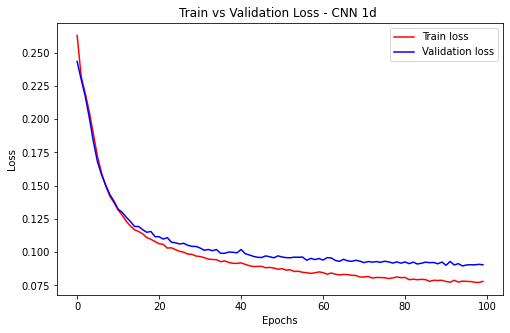

CPU times: user 145 ms, sys: 2.02 ms, total: 147 ms
Wall time: 146 ms


In [66]:
%%time

n = 100

# Plotting the test accuracy results for SGD Optimizer
epochs_range = range(0,epochs)
plt.figure(figsize=(8,5))
plt.plot(epochs_range[:n], epoch_loss[:n], color='red', 
         label='Train loss')
plt.plot(epochs_range[:n], validation_epoch_loss[:n], color='blue', 
         label='Validation loss')
plt.title('Train vs Validation Loss - CNN 1d ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predicting the 2 test audio files

In [28]:
model2.eval()

test01_hat_cnn1d = model2(torch.from_numpy(X_test_01_mag).float().to(device))
spectogram_test1_cnn1d = recover_sound(X_test_01, X_test_01_mag.T, test01_hat_cnn1d.T.detach().cpu().numpy() ) 

test02_hat_cnn1d = model2(torch.from_numpy(X_test_02_mag).float().to(device))
spectogram_test2_cnn1d = recover_sound(X_test_02, X_test_02_mag.T, test02_hat_cnn1d.T.detach().cpu().numpy() ) 

In [29]:
recover_test01_cnn1d = librosa.istft(spectogram_test1_cnn1d, hop_length= 512, win_length=1024)
recover_test02_cnn1d = librosa.istft(spectogram_test2_cnn1d, hop_length= 512, win_length=1024)

In [30]:
output_file_01_cnn1d = '/content/drive/MyDrive/data/test_s_01_recovered_cnn1d.wav'
output_file_02_cnn1d = '/content/drive/MyDrive/data/test_s_02_recovered_cnn1d.wav'
sf.write(output_file_01_cnn1d, recover_test01_cnn1d, sr)
sf.write(output_file_02_cnn1d, recover_test02_cnn1d, sr)

### Listen to original and predicted audio files

**Original test_x_01.wav**

In [31]:
ipd.Audio('/content/drive/MyDrive/data/test_x_01.wav')

**Reconstructed Audio test_s_01_recovered.wav for cnn1d model**

In [32]:
ipd.Audio(output_file_01_cnn1d)

**Original test_x_02.wav**

In [33]:
ipd.Audio('/content/drive/MyDrive/data/test_x_02.wav')

**Reconstructed Audio test_s_02_recovered.wav**

In [34]:
ipd.Audio(output_file_02_cnn1d)

## 03. Speech Denoising Using 2D CNN

In [35]:
# Reading the training file

file_s_input = '/content/drive/MyDrive/data/train_clean_male.wav'
file_x_input = '/content/drive/MyDrive/data/train_dirty_male.wav'
file_test_01 = '/content/drive/MyDrive/data/test_x_01.wav'
file_test_02 = '/content/drive/MyDrive/data/test_x_02.wav'

s, sr=librosa.load(file_s_input, sr=None) 
S=librosa.stft(s, n_fft=1024, hop_length=512)

sn, sr=librosa.load(file_x_input, sr=None) 
X=librosa.stft(sn, n_fft=1024, hop_length=512)

# Reading test 01 file
st_01, sr_01=librosa.load(file_test_01, sr=None) 
X_test=librosa.stft(st_01, n_fft=1024, hop_length=512)

# Reading test 02 file
st_02, sr_02=librosa.load(file_test_02, sr=None) 
X_test2=librosa.stft(st_02, n_fft=1024, hop_length=512)


In [36]:

#Calculating the magnitude of all the input files
mag_S = np.abs(S)
mag_X = np.abs(X)
mag_X_test = np.abs(X_test)
mag_X_test2 = np.abs(X_test2)
mag_X_test.shape,mag_X_test2.shape

((513, 142), (513, 380))

In [37]:
def transform_data(x , size , window_size):
  temp = x[0 : 0 + window_size,:]
  for i in range(1 , size - window_size + 1):
      temp_mini = x[i : i + window_size,:]
      temp = np.vstack((temp , temp_mini))
  print(temp.shape)
  return temp

In [38]:
#Transforming the data in such a way that it takes 20 current and previous input frames
transformed_x = transform_data(mag_X.T , np.shape(mag_X.T)[0] , 20)

(48800, 513)


In [39]:
#Transforming the input data into 2D format

transformed_x = np.reshape(transformed_x , (2440 , 20 , 513))

In [40]:
transformed_x.shape

(2440, 20, 513)

In [41]:
#Keeping a copy of transformed x because we will require it later on to calculate the SNR
transformed_x1 = transformed_x
transformed_x1.shape

(2440, 20, 513)

In [42]:
#Dropping first 19 frames from y(clean wave) signal

transformed_y = (mag_S.T)[19 : , :]
transformed_y.shape

(2440, 513)

In [43]:
X_m = torch.from_numpy(transformed_x)
Y_m = torch.from_numpy(transformed_y)
X_true_m = torch.from_numpy(np.abs(X.T[19:,:]))
X_torch = torch.from_numpy(X.T[19:,:])
Y_torch = torch.from_numpy(S.T[19:,:])
true_label = S.T[19:,:]

In [44]:
X_m.shape,Y_m.shape,X_true_m.shape,X_torch.shape,Y_torch.shape

(torch.Size([2440, 20, 513]),
 torch.Size([2440, 513]),
 torch.Size([2440, 513]),
 torch.Size([2440, 513]),
 torch.Size([2440, 513]))

In [45]:
n_epochs = 500
batch_size = 100
input_size = 29184
hidden_size =750
out_size = 513

In [46]:
class ConvNueralNet(nn.Module):
  
  def __init__(self,input_size,hidden_size,out_size):
    super().__init__()
    #self.conv1d = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1)
    self.conv1d = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(2,2), stride=(1,1))
    self.batchnorm = nn.BatchNorm2d(3,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True,)
    self.flatten =nn.Flatten(start_dim=1)
    self.l1 = nn.Linear(input_size,hidden_size,bias=True)
    self.l2 = nn.Linear(hidden_size,out_size,bias = True)
    self.dropout = nn.Dropout(p=0.25, inplace=False)
    #Activaltion function ReLU based on user request 
    self.act_fun = nn.ReLU()

  #Feed Forward network
  def forward(self,x):
    #print("Layer 0: ",x.shape)
    out1 = self.act_fun(self.conv1d(x))
    #print("Layer 1: ",out1.shape)
    out2 = self.batchnorm(out1)
    #print("Layer 2: ",out2.shape)
    out3 = self.flatten(out2)
    #print("Layer 3: ",out3.shape)
    out4 = self.act_fun(self.l1(out3))
    #print("Layer 4: ",out4.shape)
    out5 = self.act_fun(self.l2(self.dropout(out4)))
    #print("Layer 5: ",out5.shape)
    return out5

In [47]:
model = ConvNueralNet(input_size,hidden_size,out_size).float().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.MSELoss()

In [48]:
train_loss = torch.zeros(n_epochs,dtype=torch.float32)
test_loss = torch.zeros(n_epochs,dtype=torch.float32)
SNR = torch.zeros(n_epochs,dtype=torch.float32)

for epoch in range(n_epochs):
    model.train()
    #permutation = torch.randperm(X_m.size()[0])
    permutation = torch.arange(X_m.size()[0])
    trn_loss = 0.0
    snr_ratio =0.0
    count =0
    for i in range(0,X_m.size()[0], batch_size):
        
        count +=1
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_m[indices].to(device), Y_m[indices].to(device)
        #batch_x_true_m,batch_x_true,batch_true_y = X_true_m[indices].to(device),X_torch[indices].to(device),true_label[indices]
        outputs = model(batch_x[:,None,:].float()).to(device)
        loss = criterion(outputs,batch_y.float()).to(device)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()

    train_loss[epoch] = trn_loss
    if (epoch+1)%10 == 0:
      print("Epoch : ",epoch+1," Train Loss : ",trn_loss)

Epoch :  10  Train Loss :  0.6028563799336553
Epoch :  20  Train Loss :  0.4006870733574033
Epoch :  30  Train Loss :  0.3318604058586061
Epoch :  40  Train Loss :  0.31731782271526754
Epoch :  50  Train Loss :  0.33834662893787026
Epoch :  60  Train Loss :  0.27073295833542943
Epoch :  70  Train Loss :  0.2450068616308272
Epoch :  80  Train Loss :  0.24954446335323155
Epoch :  90  Train Loss :  0.23942899191752076
Epoch :  100  Train Loss :  0.21598175400868058
Epoch :  110  Train Loss :  0.21299343253485858
Epoch :  120  Train Loss :  0.19868946843780577
Epoch :  130  Train Loss :  0.19881194247864187
Epoch :  140  Train Loss :  0.18760867358651012
Epoch :  150  Train Loss :  0.18295345385558903
Epoch :  160  Train Loss :  0.1751377551117912
Epoch :  170  Train Loss :  0.17230975115671754
Epoch :  180  Train Loss :  0.1681570754153654
Epoch :  190  Train Loss :  0.16833013575524092
Epoch :  200  Train Loss :  0.15523972210939974
Epoch :  210  Train Loss :  0.15701156784780324
Epoch :

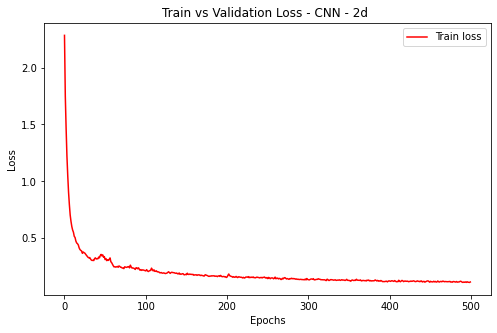

CPU times: user 241 ms, sys: 24.3 ms, total: 265 ms
Wall time: 257 ms


In [67]:
%%time

n = 500

# Plotting the test accuracy results for SGD Optimizer
epochs_range = range(0,n_epochs)
plt.figure(figsize=(8,5))
plt.plot(epochs_range[:n], train_loss[:n], color='red', 
         label='Train loss')
# plt.plot(epochs_range[:n], validation_epoch_loss[:n], color='blue', 
#          label='Validation loss')

plt.title('Train vs Validation Loss - CNN - 2d ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Testing

In [51]:
#Calculating the output from the given input, trained model and layer number
def feedforward(input_data, model):
    output = model(torch.from_numpy(input_data[:,None,:]).float().to(device)).to('cpu').detach().numpy()
    return output

#Recovering the complex values of the file from the output of the model
def recover_sound(X , mag_X , mag_output):
  temp = X / mag_X
  s_hat = temp * mag_output
  
  return s_hat

#Recovering the lost frames
def recover_data(x , size , value):
  temp = np.full(size , value)
  output = np.vstack((temp , x))
  print(output.shape)
  return output

In [52]:
#Transforming the data in such a way that it be given to the model for testing
transformed_x_test = transform_data(mag_X_test.T , np.shape(mag_X_test.T)[0] , 20)
transformed_x_test2 = transform_data(mag_X_test2.T , np.shape(mag_X_test2.T)[0] , 20)
transformed_x_test.shape,transformed_x_test2.shape

(2460, 513)
(7220, 513)


((2460, 513), (7220, 513))

In [53]:
transformed_x_test = np.reshape(transformed_x_test , (np.shape(mag_X_test.T)[0] - 19, 20 , 513))
transformed_x_test.shape

(123, 20, 513)

In [54]:
transformed_x_test2 = np.reshape(transformed_x_test2 , (np.shape(mag_X_test2.T)[0] -19 , 20 , 513))
transformed_x_test2.shape

(361, 20, 513)

In [55]:
window_size = 20
#Computing the output from the model for both the test files
s_hat_test1 = feedforward(transformed_x_test , model)
s_hat_test2 = feedforward(transformed_x_test2 , model)

#Recovering the first 19 frames that were lost
recovered_x_test1 = recover_data(s_hat_test1 , (window_size - 1 , np.shape(s_hat_test1)[1]) , 1e-15)
recovered_x_test2 = recover_data(s_hat_test2 , (window_size - 1 , np.shape(s_hat_test2)[1]) , 1e-15)

#Recovering the complex values of both the test files
s_hat1 = recover_sound(X_test , mag_X_test , recovered_x_test1.T)
s_hat2 = recover_sound(X_test2 , mag_X_test2 , recovered_x_test2.T)

(142, 513)
(380, 513)


In [56]:
#Reconstructing the test files after removing noise
recon_sound = librosa.istft(s_hat1 , hop_length=512 , win_length=1024)
sf.write('test_s10_01_recons_q2.wav', recon_sound, sr)

recon_sound = librosa.istft(s_hat2 , hop_length=512 , win_length=1024)
sf.write('test_s10_02_recons_q2.wav', recon_sound, sr)

In [57]:
ipd.Audio('test_s10_01_recons_q2.wav')


In [58]:
ipd.Audio('test_s10_02_recons_q2.wav')

In [59]:
#For testing purpose, feeding the model with train_dirty_male file
#From the output generated, reconstructing the audio file
s_hat_test3 = feedforward(transformed_x , model)
recovered_x1 = recover_data(s_hat_test3 , (window_size - 1 , np.shape(s_hat_test3)[1]) , 1e-15)
s_hat3 = recover_sound(X, mag_X , recovered_x1.T)
recon_sound3 = librosa.istft(s_hat3 , hop_length=512 , win_length=1024)
size_recon_sound3 = np.shape(recon_sound3)[0]

(2459, 513)


In [60]:
size_recon_sound3

1258496

In [68]:
sf.write('train_s10_01_recons_q3.wav', recon_sound3, sr)
ipd.Audio('train_s10_01_recons_q3.wav')

In [62]:
#Once the audio file is generated, calculating the SNR value
s = s[: size_recon_sound3]
num = np.dot(s.T , s)
den = np.dot((s - recon_sound3).T,(s - recon_sound3))
SNR = 10 * np.log10(num/den)
print('Value of SNR : ' + str(SNR))

Value of SNR : 7.857881284723367


## Convert the notebook to HTML

In [64]:
%%shell
jupyter nbconvert --to html /content/AG_DLS_HW_2_PT.ipynb

[NbConvertApp] Converting notebook /content/AG_DLS_HW_2_PT.ipynb to html
[NbConvertApp] Writing 7451547 bytes to /content/AG_DLS_HW_2_PT.html


# **The END**
